In [1]:
!ls ../GW_data/
print()
!ls ../noise1/
print()
!ls ../dataset1/output/
print()
!ls ../dataset2/output/
print()
!ls ../dataset3/output/

GW_test_full.csv	 GW_test_nfull.csv	   GW_train_m125_m275.0.csv
GW_test_m110_m271.0.csv  GW_train_full.csv	   GW_train_nfull.csv
GW_test_m126_m272.8.csv  GW_train_m111_m266.0.csv

LigoNose9_9000_8192_1.csv  LigoNose9_9000_8192_2.csv

LigoNose9_9000_8192_3.csv  test_data_05.csv   train_data_05.csv
LigoNose9_9000_8192_4.csv  test_data_1.csv    train_data_1.csv
LigoNose9_9000_8192_5.csv  test_data_10.csv   train_data_10.csv
LigoNose9_9000_8192_6.csv  test_data_5.csv    train_data_5.csv
test_data_03.csv	   train_data_03.csv

test_data_101.csv  test_data_106.csv   train_data_102.csv  train_data_107.csv
test_data_102.csv  test_data_107.csv   train_data_103.csv  train_data_108.csv
test_data_103.csv  test_data_108.csv   train_data_104.csv  train_data_109.csv
test_data_104.csv  test_data_109.csv   train_data_105.csv
test_data_105.csv  train_data_101.csv  train_data_106.csv

test_data_0.1.csv  test_data_2.csv  train_data_0.1.csv	train_data_2.csv
test_data_0.2.csv  test_data_3.csv  train_data_0.2

In [2]:
# importing the library
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 

import time

!mkdir images


mkdir: cannot create directory ‘images’: File exists


In [53]:
plt.rcParams['figure.figsize'] = (10 ,6)
plt.rcParams['axes.linewidth'] = 1.3
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['savefig.dpi'] = 300

In [4]:
# import OpenSSL.SSL
from __future__ import print_function
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon
import random

In [ ]:
mx.random.seed(1)
random.seed(1)

In [ ]:
try:
    ctx = mx.gpu()
    _ = nd.zeros((1,), ctx=ctx)
except:
    ctx = mx.cpu()
ctx

gpu(0)

In [ ]:
# zero mean and unit variance as it makes traning process easier
def Normolise(data):
    data_array = np.array(data)
    data_array_shape = data_array.shape[0]
    return pd.DataFrame((data_array -np.mean(data_array, axis=1).reshape(data_array_shape,-1))/np.std(data_array, axis=1).reshape(data_array_shape,-1)
                        ,index = data.index)
def init_params(num_fc = 64, num_outputs = 2):
    #######################
    #  Set the scale for weight initialization and choose
    #  the number of hidden units in the fully-connected layer
    #######################
    weight_scale = .01

    W1 = nd.random_normal(shape=(16, 1, 1, 16), scale=weight_scale, ctx=ctx)
    b1 = nd.random_normal(shape=16, scale=weight_scale, ctx=ctx)

    W2 = nd.random_normal(shape=(32, 16, 1, 8), scale=weight_scale, ctx=ctx)
    b2 = nd.random_normal(shape=32, scale=weight_scale, ctx=ctx)

    W3 = nd.random_normal(shape=(64, 32, 1, 8), scale=weight_scale, ctx=ctx)
    b3 = nd.random_normal(shape=64, scale=weight_scale, ctx=ctx)
    #  29056
    W4 = nd.random_normal(shape=(64256, num_fc), scale=weight_scale, ctx=ctx)
    b4 = nd.random_normal(shape=num_fc, scale=weight_scale, ctx=ctx)

    W5 = nd.random_normal(shape=(num_fc, num_outputs), scale=weight_scale, ctx=ctx)
    b5 = nd.random_normal(shape=num_outputs, scale=weight_scale, ctx=ctx)

    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5]

    vs = []
    sqrs = []    
    
    # And assign space for gradients
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())        
    return params, vs, sqrs


# CNN model
def net(X, params, debug=False):
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5] = params
    ########################
    #  Define the computation of the first convolutional layer
    ########################
    h1_conv = nd.Convolution(data=X, weight=W1, bias=b1, kernel=(1,16), num_filter=16, stride=(1,1))
    h1_activation = relu(h1_conv)
    h1 = nd.Pooling(data=h1_activation, pool_type="avg", kernel=(1,16), stride=(1,2))
    if debug:
        print("h1 shape: %s" % (np.array(h1.shape)))

    ########################
    #  Define the computation of the second convolutional layer
    ########################
    h2_conv = nd.Convolution(data=h1, weight=W2, bias=b2, kernel=(1,8), num_filter=32, stride=(1,1))
    h2_activation = relu(h2_conv)
    h2 = nd.Pooling(data=h2_activation, pool_type="avg", kernel=(1,16), stride=(1,2))
    if debug:
        print("h2 shape: %s" % (np.array(h2.shape)))
        
    ########################
    #  Define the computation of the third convolutional layer
    ########################
    h3_conv = nd.Convolution(data=h2, weight=W3, bias=b3, kernel=(1,8), num_filter=64, stride=(1,1))
    h3_activation = relu(h3_conv)
    h3 = nd.Pooling(data=h3_activation, pool_type="avg", kernel=(1,16), stride=(1,2))
    if debug:
        print("h3 shape: %s" % (np.array(h3.shape)))

    ########################
    #  Flattening h3 so that we can feed it into a fully-connected layer
    ########################
    h4 = nd.flatten(h3)
    if debug:
        print("Flat h4 shape: %s" % (np.array(h4.shape)))

    ########################
    #  Define the computation of the 4th (fully-connected) layer
    ########################
    h5_linear = nd.dot(h4, W4) + b4
    h5 = relu(h5_linear)
    if debug:
        print("h4 shape: %s" % (np.array(h5.shape)))

    ########################
    #  Define the computation of the output layer
    ########################
    yhat_linear = nd.dot(h5, W5) + b5
    if debug:
        print("yhat_linear shape: %s" % (np.array(yhat_linear.shape)))
    
    interlayer = [h1, h2, h3, h4, h5]
    
    return yhat_linear, interlayer

# Non-linear function.
def relu(X):
    return nd.maximum(X,nd.zeros_like(X))

# Loss function.
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    partition = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition
def softmax_cross_entropy(yhat_linear, y):   # 交叉熵损失
    return - nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

def mkdir_checkdir(path = "/output"):
    isExists = os.path.exists(path)
    if not isExists:
        os.mkdir(path)
        print('MKDIR: ' + path + ' successful!')
    else:
        print(path + " have existed!")

In [ ]:
# Mini-batch stochastic gradient descent.
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
        
# Adam.
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        g = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * g
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)
        param[:] = param - div

In [ ]:
def evaluate_accuracy(data_iterator, num_examples, batch_size, params, net):
    numerator = 0.
    denominator = 0.
    for batch_i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output, _ = net(data, params)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        print('Evaluating accuracy. (complete percent: %.2f/100' %(1.0 * batch_i / (num_examples//batch_size) * 100) +')' , end='')
        sys.stdout.write("\r")
    return (numerator / denominator).asscalar()

In [ ]:
%matplotlib inline
import sys  
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def Train(train, test, Debug, batch_size, lr, smoothing_constant, num_fc, num_outputs, epochs, params_init=None, period=None):
    
    num_examples = train.shape[0]
    # 训练集数据类型转换
    y = nd.array(~train.sigma.isnull() +0)
    X = nd.array(Normolise(train.drop(['mass','positions','gaps','max_peak','sigma'],axis=1)))
    print('Label for training:', y.shape)
    print('Dataset for training:', X.shape, end='\n\n')

    dataset_train = gluon.data.ArrayDataset(X, y)
    train_data = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='discard')

    y = nd.array(~test.sigma.isnull() +0)
    X = nd.array(Normolise(test.drop(['mass','positions','gaps','max_peak','sigma'],axis=1)))
    print('Label for testing:', y.shape)
    print('Dataset for testing:', X.shape, end='\n\n')
    
    # 这里使用data模块来读取数据。创建测试数据。  (不shuffle)
    dataset_test = gluon.data.ArrayDataset(X, y)
    test_data = gluon.data.DataLoader(dataset_test, batch_size, shuffle=False, last_batch='discard')

    
    # Train
    loss_history = []
    moving_loss_history = []
    test_accuracy_history = []
    train_accuracy_history = []
    
#     assert period >= batch_size and period % batch_size == 0
    
    # Initializate parameters
    if params_init:
        print('Loading params...')
        params = params_init
        vs = []
        sqrs = [] 
        for param in params:
            param.attach_grad()
            vs.append(param.zeros_like())
            sqrs.append(param.zeros_like())              
    else:
        params, vs, sqrs = init_params(num_fc, num_outputs)
        
    # Debug
    if Debug:
        print('Debuging...')
        if params_init:
            params = params_init
        else:
            params, vs, sqrs = init_params(num_fc, num_outputs)
        for data, _ in train_data:
            data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
            break
        _, _ = net(data, params, debug=Debug)
        print()    
    
#     total_loss = [Total_loss(train_data_10, params, batch_size, num_outputs)]
    
    t = 0
#   Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        Epoch_loss = []
#         学习率自我衰减。
#         if epoch > 2:
#             lr *= 0.1
        for batch_i, (data, label) in enumerate(train_data):
            data = data.as_in_context(ctx).reshape((batch_size,1,1,-1))
            label = label.as_in_context(ctx)
            label_one_hot = nd.one_hot(label, num_outputs)
            with autograd.record():
                output, _ = net(data, params)
                loss = softmax_cross_entropy(output, label_one_hot)
            loss.backward()
            
#             sgd(params, lr, batch_size)

#           Increment t before invoking adam.
            t += 1
            adam(params, vs, sqrs, lr, batch_size, t)
            
#             #########################
#              Keep a moving average of the losses
#             #########################
            curr_loss = nd.mean(loss).asscalar()
            moving_loss = (curr_loss if ((batch_i == 0) and (epoch-1 == 0))
                           else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

            loss_history.append(curr_loss)
            moving_loss_history.append(moving_loss)
            Epoch_loss.append(curr_loss)
#             if batch_i * batch_size % period == 0:
#                 print('Curr_loss: ', curr_loss)
                
            print('Working on epoch %d. Curr_loss: %.5f (complete percent: %.2f/100' %(epoch, curr_loss*1.0, 1.0 * batch_i / (num_examples//batch_size) * 100) +')' , end='')
            sys.stdout.write("\r")
            
        test_accuracy = evaluate_accuracy(test_data, num_examples, batch_size, params, net)
        train_accuracy = evaluate_accuracy(train_data, num_examples, batch_size, params, net)
        test_accuracy_history.append(test_accuracy)
        train_accuracy_history.append(train_accuracy)
    
        print("Epoch %d, Moving_loss: %.6f, Epoch_loss(mean): %.6f, Train_acc %.4f, Test_acc %.4f" %
              (epoch, moving_loss, np.mean(Epoch_loss), train_accuracy, test_accuracy))
        yield (params, loss_history, moving_loss_history, test_accuracy_history, train_accuracy_history)
        
        
sampling_freq = 8192

In [ ]:
noise3 = pd.read_csv('../dataset1/output/LigoNose9_9000_8192_3.csv', index_col=0)
# noise4 = pd.read_csv('../dataset1/output/LigoNose9_9000_8192_4.csv', index_col=0)

In [ ]:
data_train_1 = pd.read_csv('../dataset1/output/train_data_1.csv', index_col=0)
# data_test_1 = pd.read_csv('../dataset1/output/test_data_1.csv', index_col=0)
print(data_train_1.shape)
# print(data_test_1.shape)

colomns = [ str(i) for i in range(sampling_freq)] + ['mass','positions','gaps','max_peak','sigma']
train_1 = pd.concat([data_train_1, noise3.iloc[:data_train_1.shape[0],:]])[colomns]
# test_1 = pd.concat([data_test_1, noise4.iloc[:data_test_1.shape[0],:]])[colomns]
print(train_1.shape)
# print(test_1.shape)

(9856, 8197)
(19712, 8197)


In [ ]:
label_1 = nd.array(~train_1.sigma.isnull() +0)[:91]
data_1 = nd.array(Normolise(train_1.drop(['mass','positions','gaps','max_peak','sigma'],axis=1)))[:91]

label_0 = nd.array(~train_1.sigma.isnull() +0)[-91:]
data_0 = nd.array(Normolise(train_1.drop(['mass','positions','gaps','max_peak','sigma'],axis=1)))[-91:]

# label = nd.array(~train_1.sigma.isnull() +0)[:1000]
# data = nd.array(Normolise(train_1.drop(['mass','positions','gaps','max_peak','sigma'],axis=1)))

In [ ]:
params = nd.load('./info_1/params')

data_1 = nd.array(data_1).as_in_context(ctx).reshape((-1,1,1,8192))
label_1 = label_1.as_in_context(ctx)
label_one_hot_1 = nd.one_hot(label_1, 2)
output_1, interlayer_1 = net(data_1, params)
predictions_1 = nd.argmax(output_1, axis=1)

data_0 = nd.array(data_0).as_in_context(ctx).reshape((-1,1,1,8192))
label_0 = label_0.as_in_context(ctx)
label_one_hot_0 = nd.one_hot(label_0, 2)
output_0, interlayer_0 = net(data_0, params)
predictions_0 = nd.argmax(output_0, axis=1)

## t-sne 

In [89]:
from sklearn.manifold import TSNE

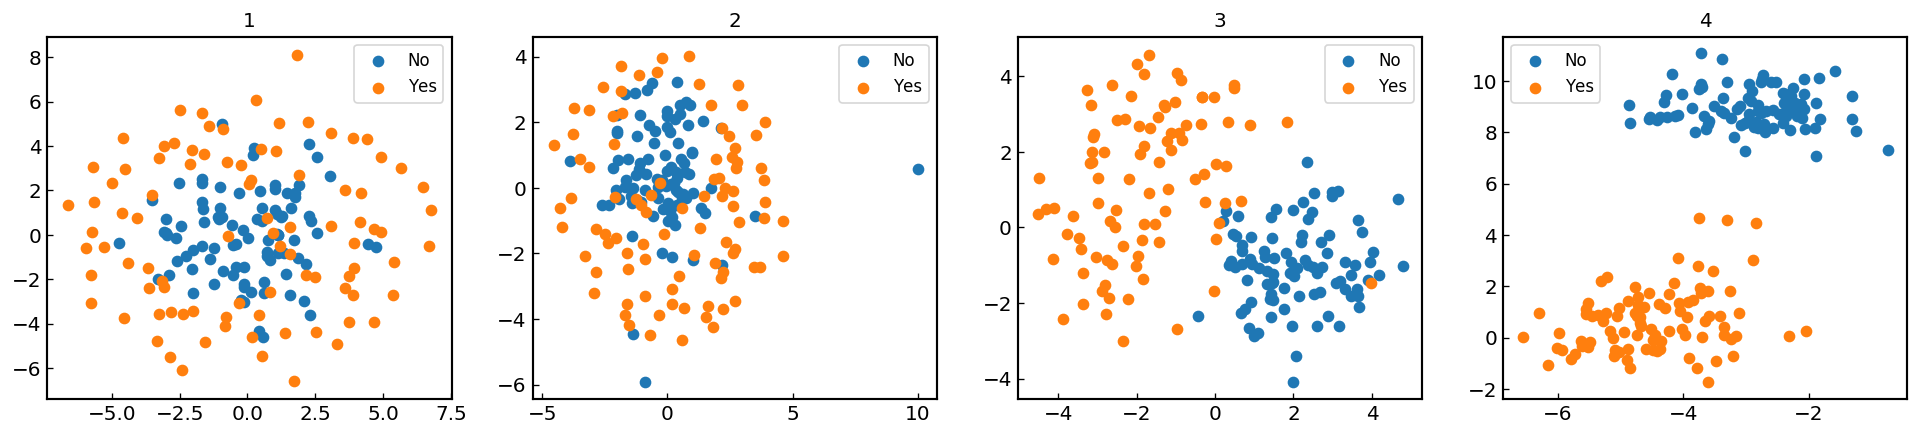

In [195]:
plt.figure(figsize=(20,4))
j = 0
for i in range(5):
    if i == 3: continue
    data_zs = nd.stack(interlayer_0[i], interlayer_1[i], axis=0).reshape((182,-1)).asnumpy()
    tsne = TSNE(random_state=1, learning_rate=500, perplexity=100.0).fit_transform(data_zs)
    plt.subplot(1,4,j+1)
    plt.scatter(tsne[:91,0],tsne[:91,1], label = 'No')
    plt.scatter(tsne[-91:,0],tsne[-91:,1], label = 'Yes')
    j+=1
    plt.title('%s' %(j))
    plt.legend()
mkdir_checkdir(path = "/images")
plt.savefig('./images/t-sne.png')

## feature maps and deconv. for hidden layers

In [16]:
data_GW_train = pd.read_csv('../GW_data/GW_train_full.csv' , index_col=0)
data_GW_test = pd.read_csv('../GW_data/GW_test_full.csv' , index_col=0)
print(data_GW_train.shape)
print(data_GW_test.shape)

(704, 8192)
(736, 8192)


In [20]:
SNR = 1
params = nd.load('./info_1/params')
data_norm = Normolise(data_GW_train.loc[['15|15.0']])
noise = noise3.sample(1,random_state = 1)

vir_noise = nd.array(noise).as_in_context(ctx).reshape((1,1,1,-1))
output_n, interlayer_n = net(vir_noise, params)
h1_n, h2_n, h3_n, h4_n, h5_n = interlayer_n


sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1))
data_mixed = data_norm.div(sigma, axis=0) + np.array(noise)
vir_mixed = nd.array(data_mixed).as_in_context(ctx).reshape((1,1,1,-1))
output_m, interlayer_m = net(vir_mixed, params)
h1_m, h2_m, h3_m, h4_m, h5_m = interlayer_m


vir_data = nd.array(data_norm.div(sigma, axis=0)).as_in_context(ctx).reshape((1,1,1,-1))
output, interlayer = net(vir_data, params)
h1, h2, h3, h4, h5 = interlayer

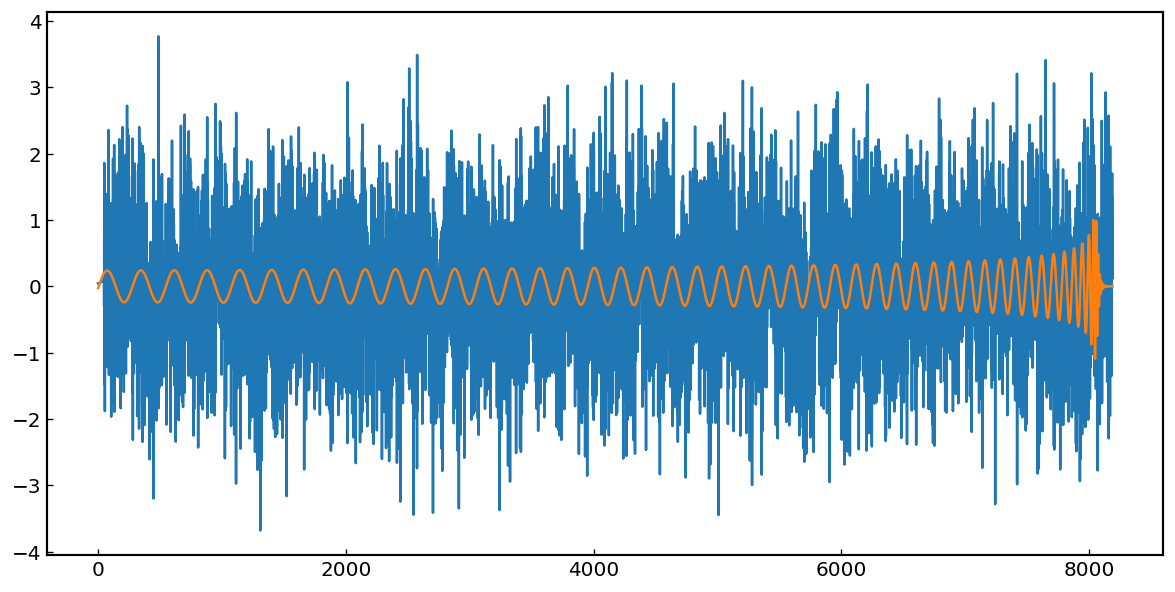

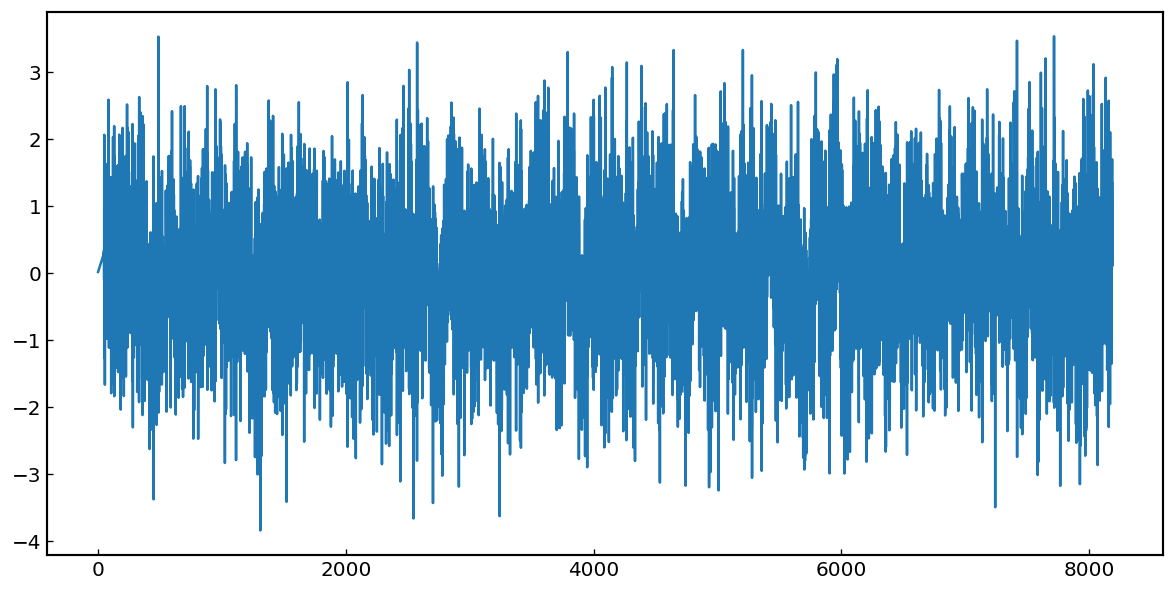

In [21]:
plt.figure(figsize=(12,6))
plt.plot(noise.values[0].tolist())
plt.plot(data_norm.div(sigma, axis=0).values[0].tolist())
# plt.figure(figsize=(12,6))
plt.savefig('./images/vir_SNR1.png')
plt.show()
plt.figure(figsize=(12,6))
plt.plot(data_mixed.values[0].tolist())
plt.savefig('./images/vir_SNR1_mixed.png')
plt.show()

(1, 16, 1, 4081)


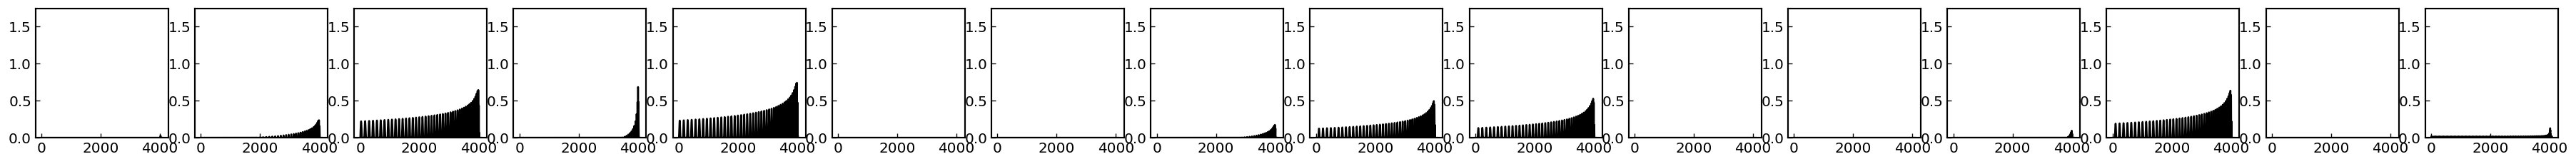

(1, 16, 1, 4081)


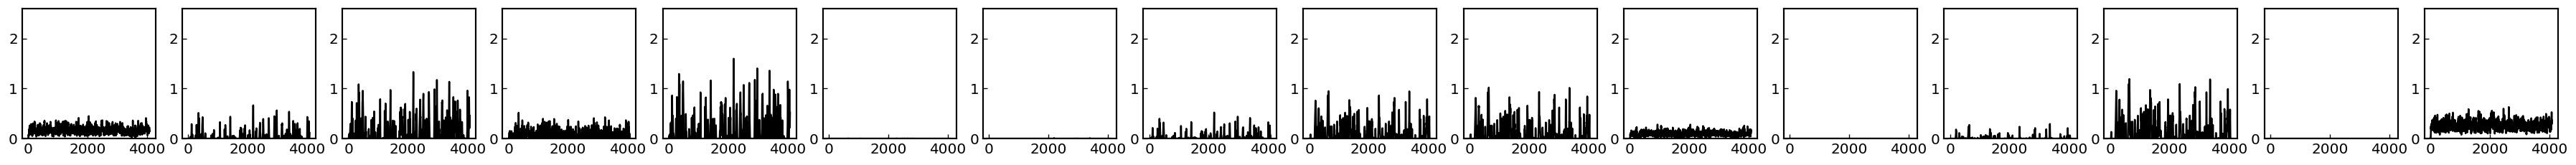

(1, 16, 1, 4081)


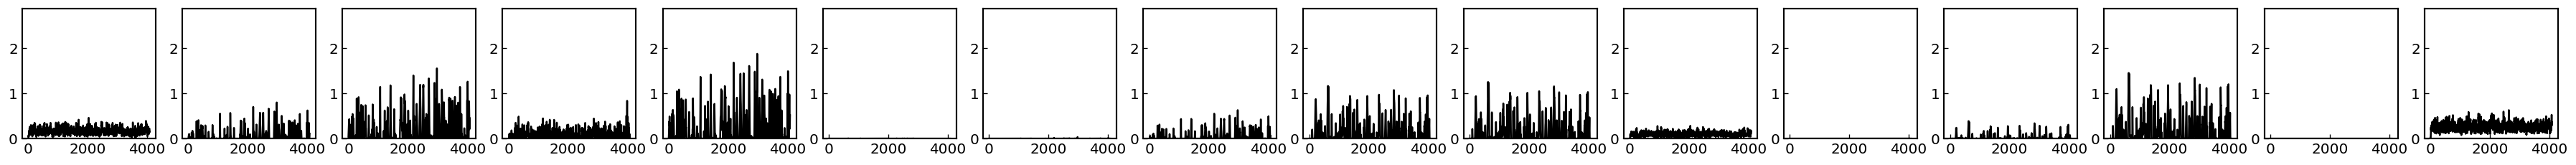

In [26]:
print(h1.shape)
plt.figure(figsize=(38,2))
# plt.subplot(1,16,1)
# for i in range(h1.shape[1]):
#     plt.plot(h1[0][i][0].asnumpy())
for i in range(1, h1.shape[1]+1):
    plt.subplot(1,16,i)
    plt.plot(h1[0][i-1][0].asnumpy() ,color = 'black')
    plt.ylim(0,h1.max().asnumpy()[0]+1)
plt.savefig("./images/h1.png")
plt.show()

print(h1_n.shape)
plt.figure(figsize=(38,2))
# plt.subplot(1,16,1)
# for i in range(h1.shape[1]):
#     plt.plot(h1[0][i][0].asnumpy())
for i in range(1, h1_n.shape[1]+1):
    plt.subplot(1,16,i)
    plt.plot(h1_n[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h1_n.max().asnumpy()[0]+1)
plt.savefig("./images/h1_n.png")
plt.show()

print(h1_m.shape)
plt.figure(figsize=(38,2))
# plt.subplot(1,16,1)
# for i in range(h1.shape[1]):
#     plt.plot(h1[0][i][0].asnumpy())
for i in range(1, h1_m.shape[1]+1):
    plt.subplot(1,16,i)
    plt.plot(h1_m[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h1_m.max().asnumpy()[0]+1)
plt.savefig("./images/h1_m.png")
plt.show()

(1, 32, 1, 2030)


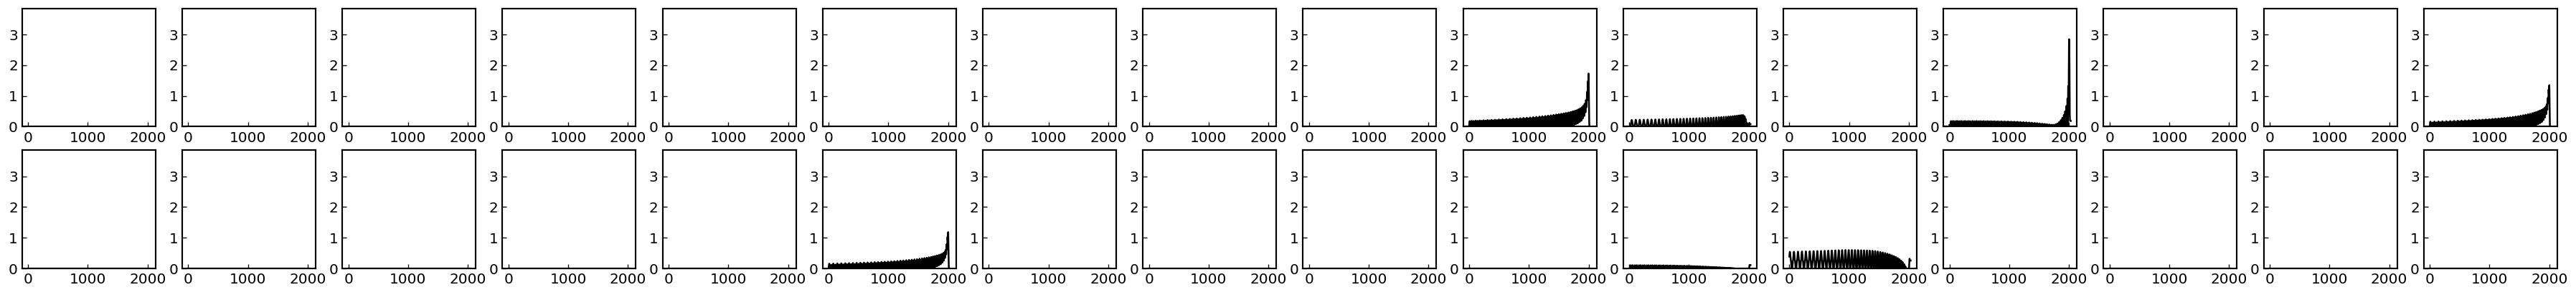

(1, 32, 1, 2030)


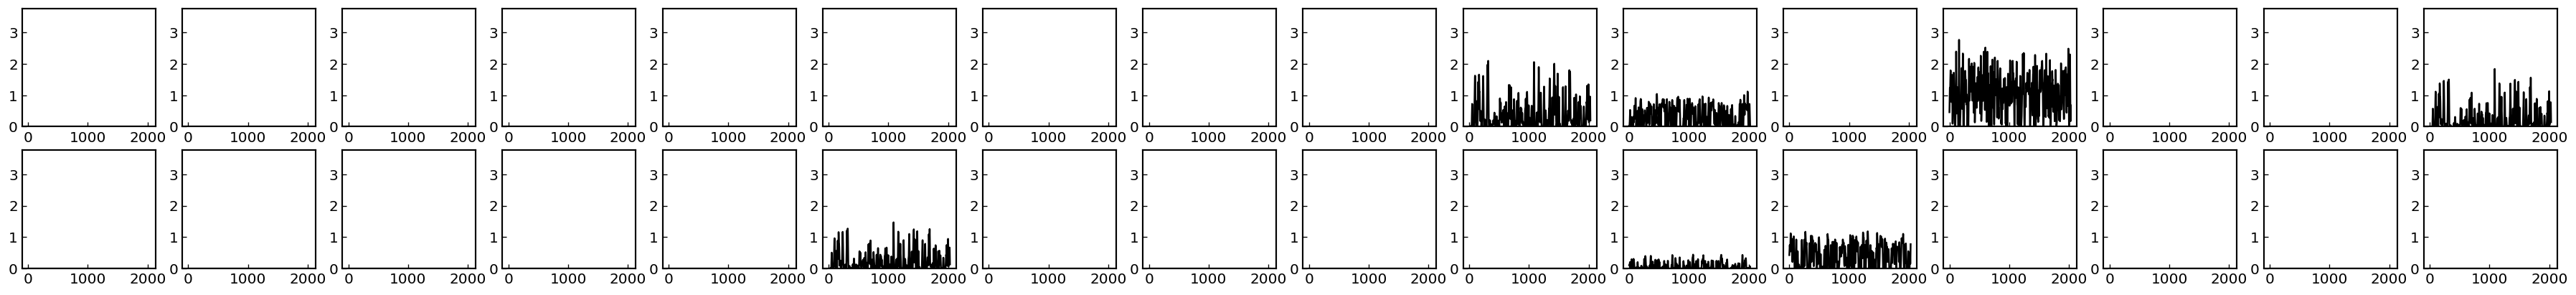

(1, 32, 1, 2030)


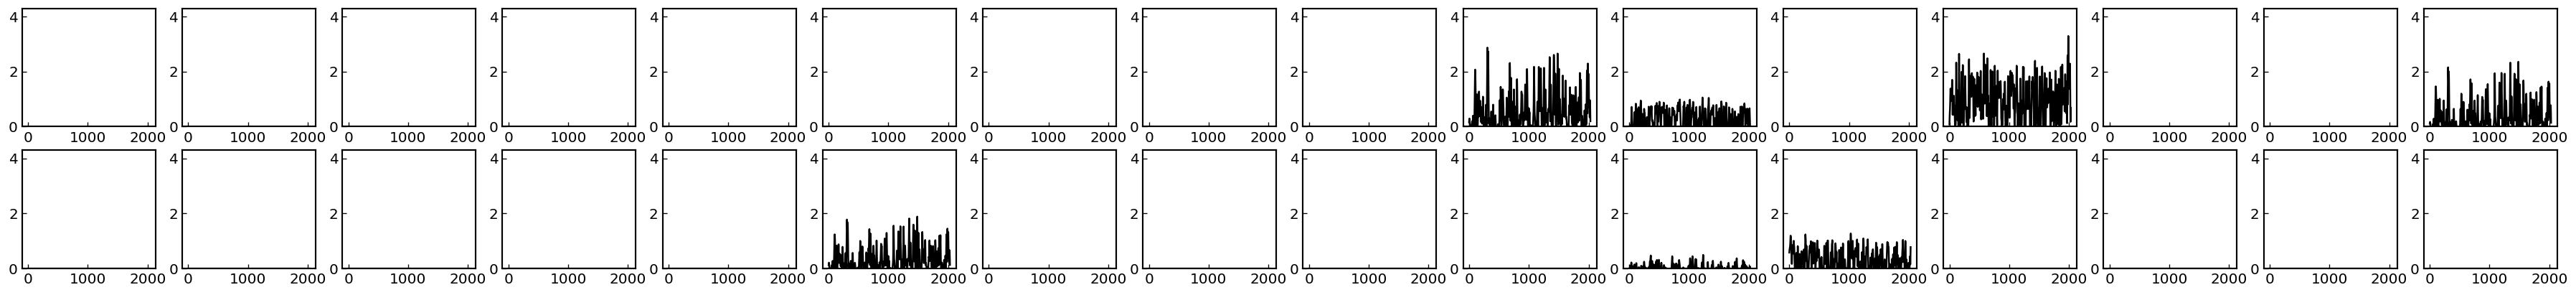

In [27]:
print(h2.shape)
plt.figure(figsize=(38,4))
for i in range(1, h2.shape[1]+1):
    plt.subplot(2,16,i)
    plt.plot(h2[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h2.max().asnumpy()[0]+1)
plt.savefig("./images/h2.png")
plt.show()

print(h2_n.shape)
plt.figure(figsize=(38,4))
for i in range(1, h2_n.shape[1]+1):
    plt.subplot(2,16,i)
    plt.plot(h2_n[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h2_n.max().asnumpy()[0]+1)
plt.savefig("./images/h2_n.png" )
plt.show()

print(h2_m.shape)
plt.figure(figsize=(38,4))
for i in range(1, h2_m.shape[1]+1):
    plt.subplot(2,16,i)
    plt.plot(h2_m[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h2_m.max().asnumpy()[0]+1)
plt.savefig("./images/h2_m.png" )
plt.show()

(1, 64, 1, 1004)


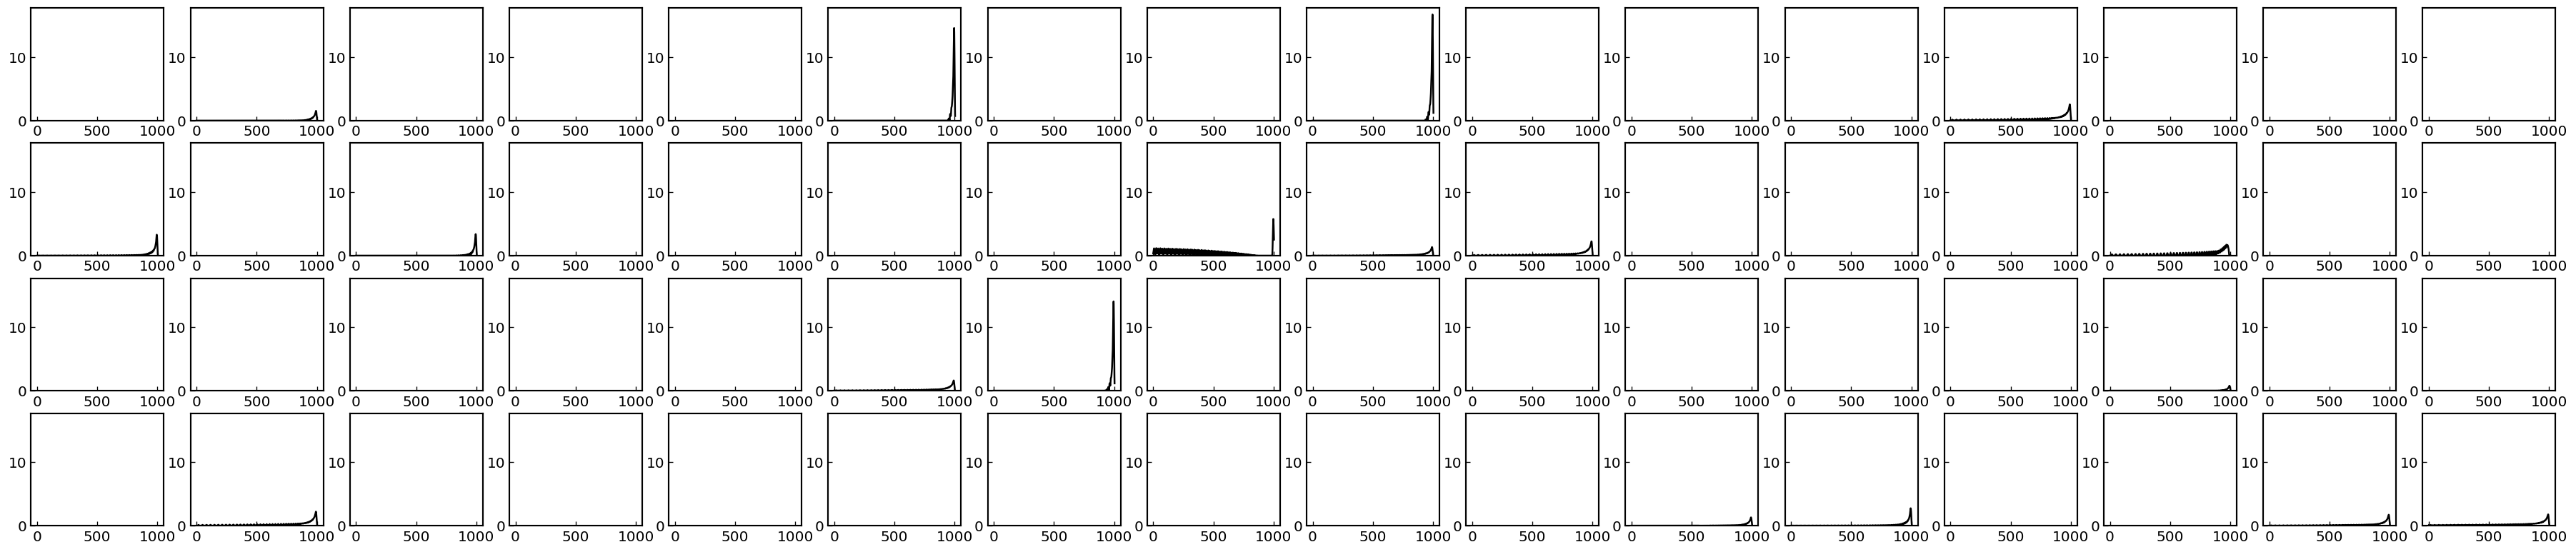

(1, 64, 1, 1004)


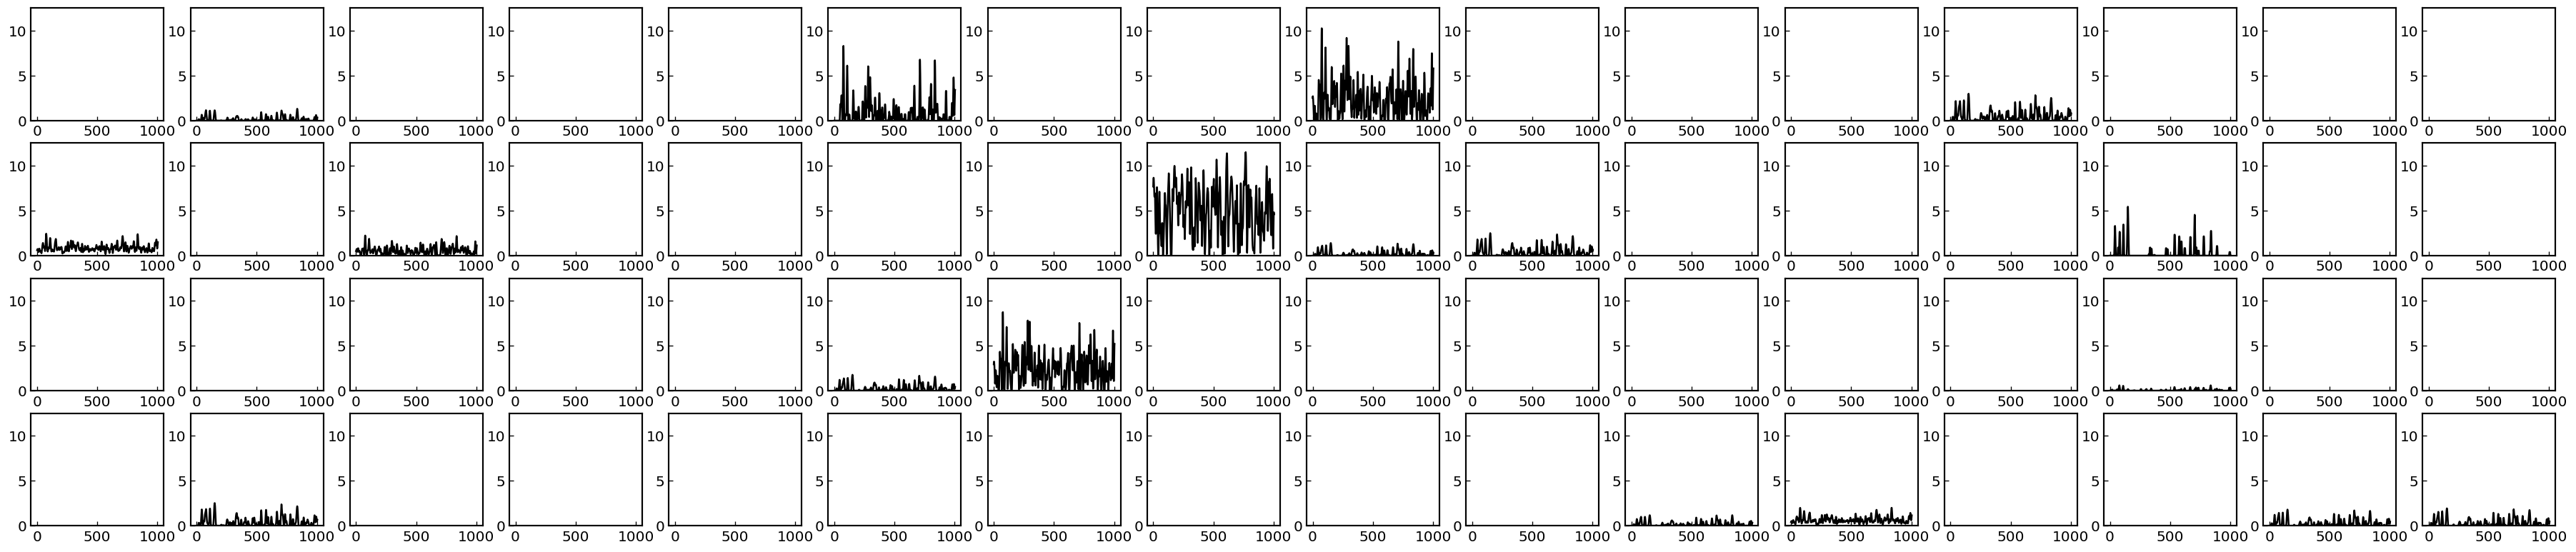

(1, 64, 1, 1004)


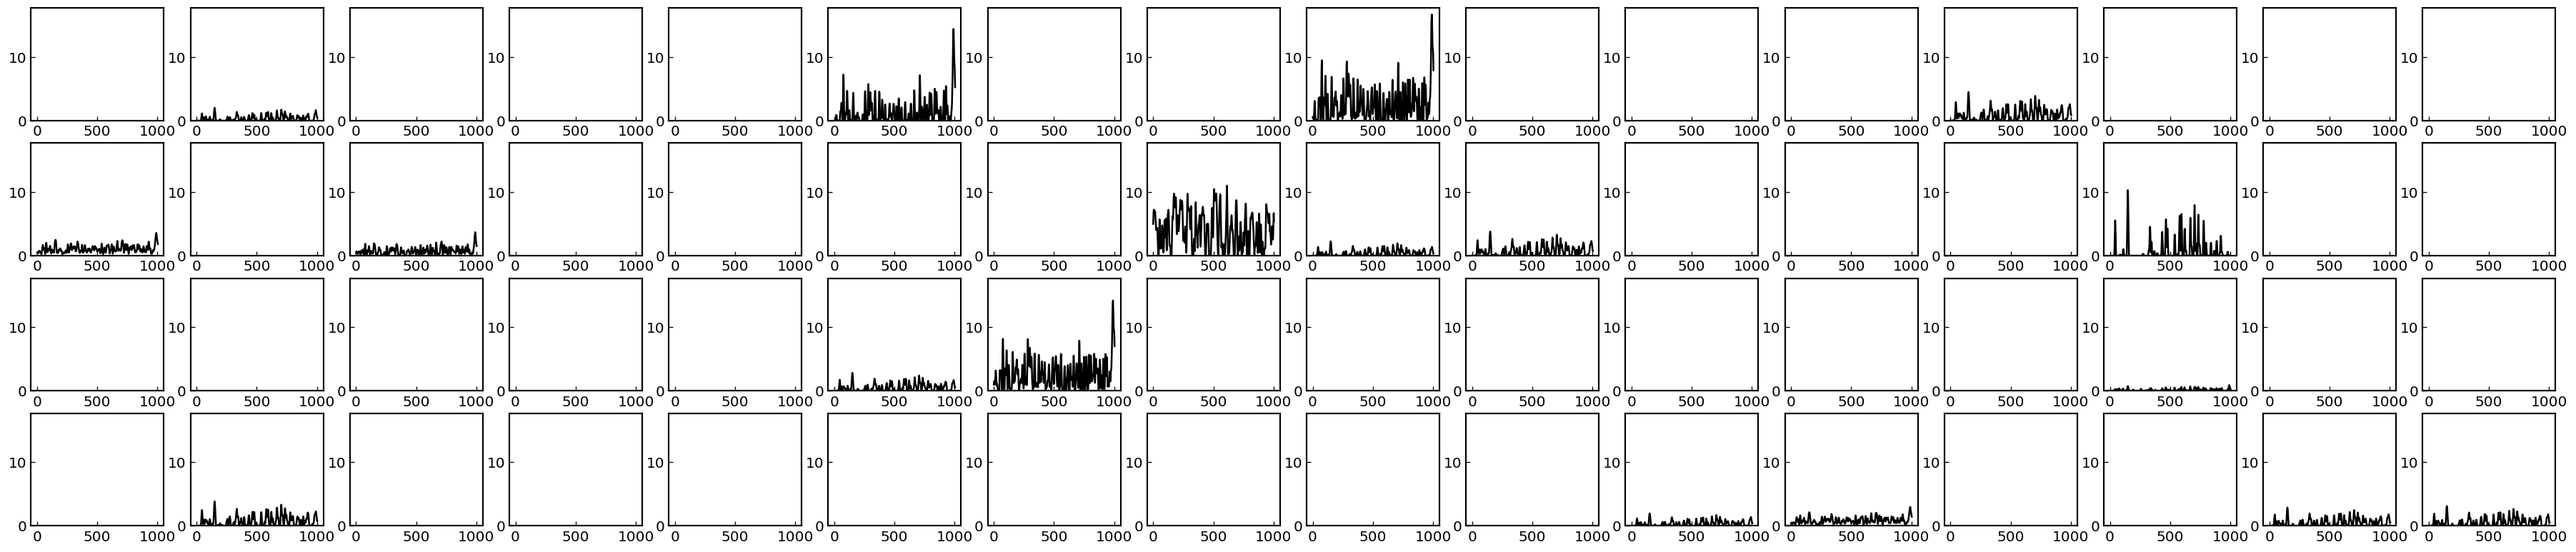

In [28]:
print(h3.shape)
plt.figure(figsize=(38,8))
for i in range(1, h3.shape[1]+1):
    plt.subplot(4,16,i)
    plt.plot(h3[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h3.max().asnumpy()[0]+1)
plt.savefig("./images/h3.png")
plt.show()

print(h3_n.shape)
plt.figure(figsize=(38,8))
for i in range(1, h3_n.shape[1]+1):
    plt.subplot(4,16,i)
    plt.plot(h3_n[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h3_n.max().asnumpy()[0]+1)
plt.savefig("./images/h3_n.png")
plt.show()

print(h3_m.shape)
plt.figure(figsize=(38,8))
for i in range(1, h3_m.shape[1]+1):
    plt.subplot(4,16,i)
    plt.plot(h3_m[0][i-1][0].asnumpy(),color = 'black')
    plt.ylim(0,h3_m.max().asnumpy()[0]+1)
plt.savefig("./images/h3_m.png")
plt.show()

(1, 64256)
(1, 64256)
(1, 64256)


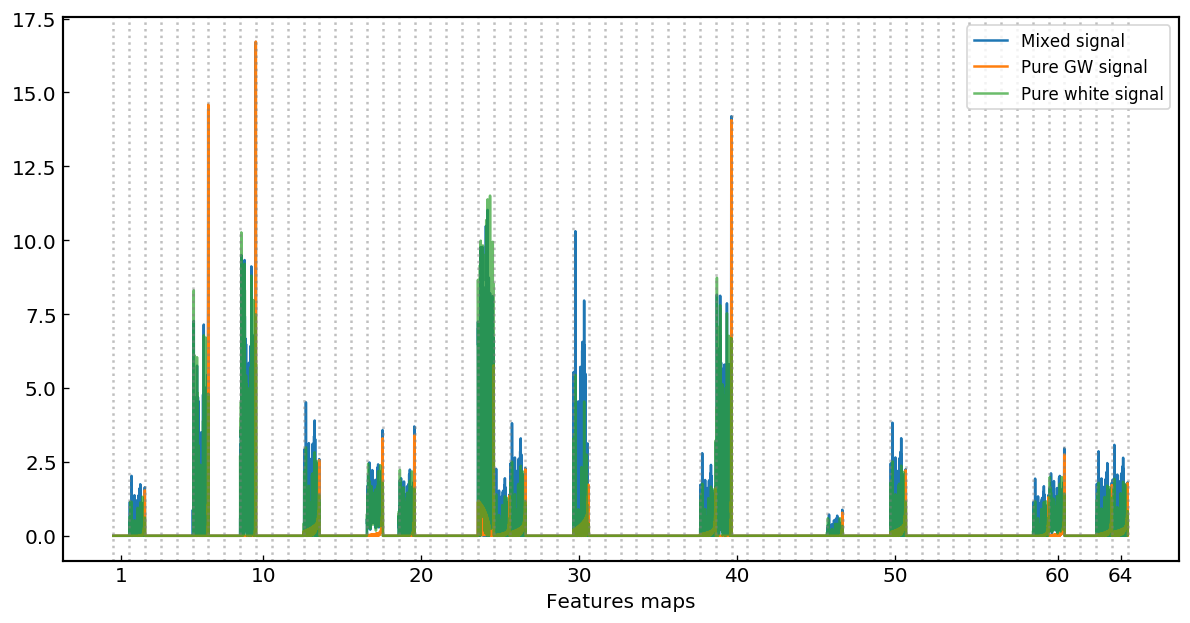

In [29]:
print(h4_m.shape)
plt.figure(figsize=(12,6))
plt.plot(h4_m[0].asnumpy(), label = 'Mixed signal')
# plt.savefig("h4_m.png")  

print(h4.shape)
# plt.figure(figsize=(12,6))
plt.plot(h4[0].asnumpy() , label = 'Pure GW signal', alpha = 1)
# plt.savefig("h4.png") 

print(h4_n.shape)
# plt.figure(figsize=(12,6))
plt.plot(h4_n[0].asnumpy(), label = 'Pure white signal', alpha = 0.7)
# plt.savefig("h4_n.png")  
plt.xlabel('Features maps')
plt.legend(loc='best', )
# plt.grid(axis = 'y')
ax=plt.gca() 
ax.set_xticks((500, 9500, 19500, 29500, 39500, 49500, 59800, 63800))
ax.set_xticklabels(('1', '10', '20', '30', '40', '50', '60', '64'))
for i in np.linspace(0, h4_m.shape[1],65):
    plt.axvline(x = [i] , color='grey', linestyle=":", alpha = 0.5)
plt.savefig('./images/h4_m_n.png')

In [31]:
def Deconv3(h3, item):
    upsam3 = mx.nd.Deconvolution(data=h3[0][item][0].reshape((1,1,1,-1))
                                     , weight=nd.ones((1,64,1,16),ctx=ctx), kernel=(1, 16) , bias = b3,no_bias=False 
                                , stride=(1, 2),num_filter=64, name="upsample3")/16
#     print(upsam3.shape)
#     upsam3 = mx.nd.relu(upsam3)

    dconv3 = mx.nd.Deconvolution(data=upsam3, weight=W3, kernel=(1, 8) #,no_bias=False 
                                , stride=(1, 1), num_filter=32,name="deconv3")
#     print(dconv3.shape)

    upsam2 = mx.nd.Deconvolution(data=dconv3, weight=nd.ones((32,32,1,16),ctx=ctx), kernel=(1, 16) , bias = b2,no_bias=False 
                                , stride=(1, 2), num_filter=32, name="upsample2")/16
#     print(upsam2.shape)
#     upsam2 = mx.nd.relu(upsam2)
    
    dconv2 = mx.nd.Deconvolution(data=upsam2, weight=W2, kernel=(1, 8)#,no_bias=False ,bias=b1
                                , stride=(1, 1),  num_filter=16, name="deconv2")
#     print(dconv2.shape)
    upsam1 = mx.nd.Deconvolution(data=dconv2, weight=nd.ones((16,16,1,16),ctx=ctx), kernel=(1, 16) , bias = b1,no_bias=False 
                                , stride=(1, 2),  num_filter=16, name="upsample1")/16
#     print(upsam1.shape)
#     upsam1 = mx.nd.relu(upsam1)
    
    dconv1 = mx.nd.Deconvolution(data=upsam1, weight=W1, kernel=(1, 16),  no_bias=True#, bias=b1.mean(),
                                , stride=(1, 1), num_filter=1, name="deconv1")
#     print(dconv1.shape)
    return dconv1[0][0][0].asnumpy().tolist()

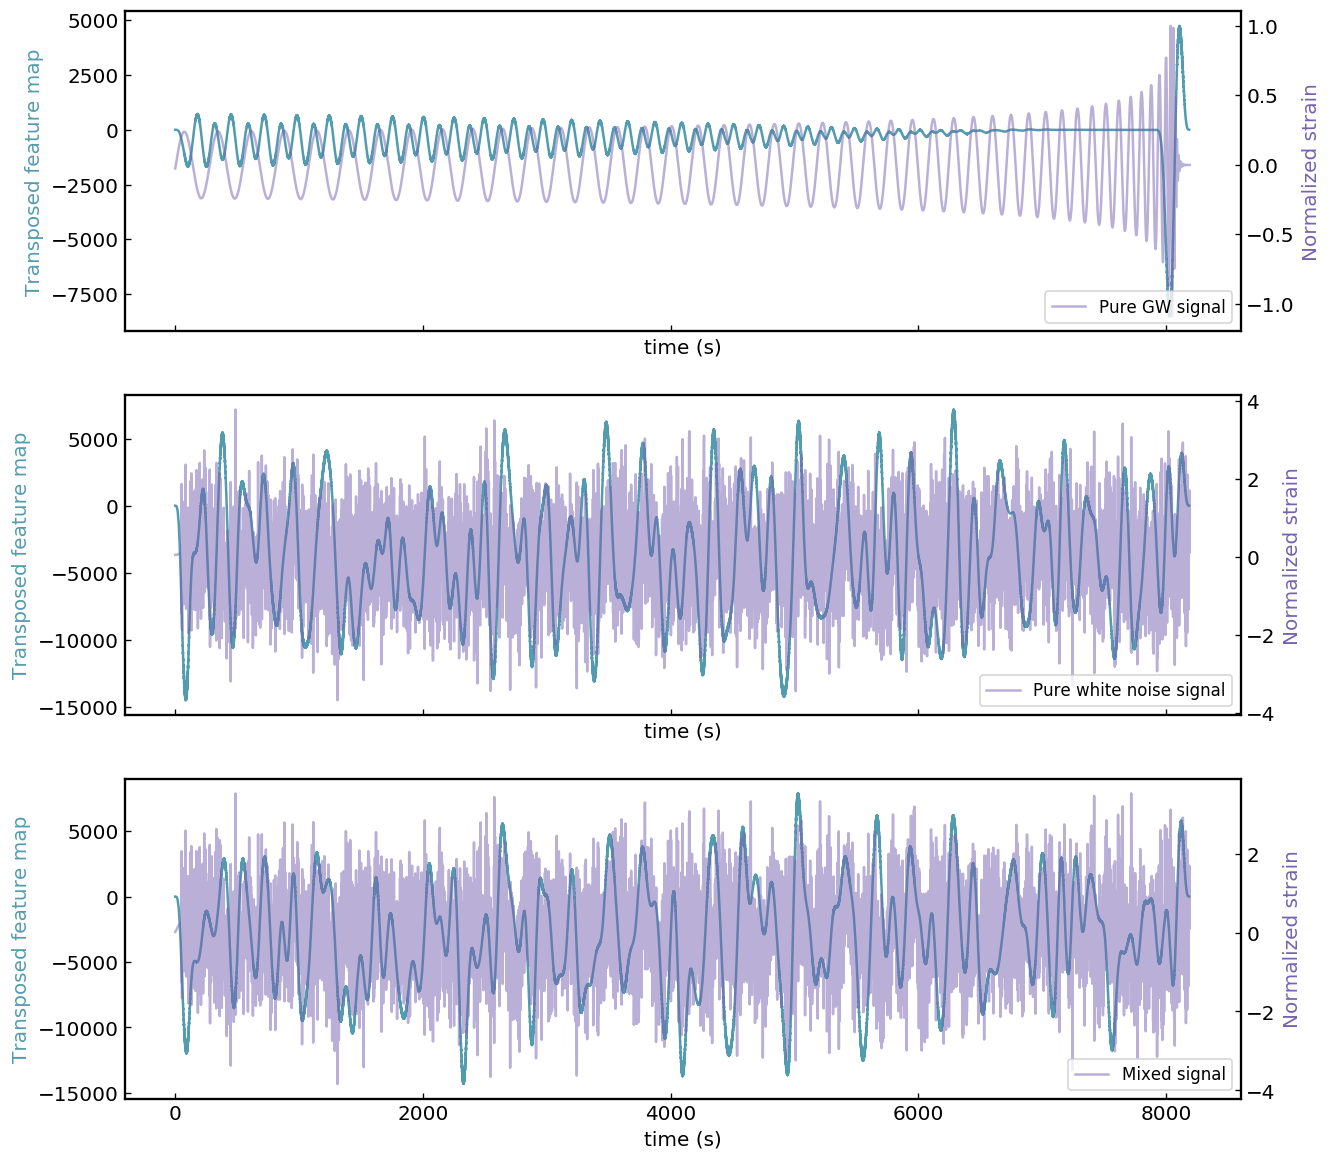

In [83]:
[W1, b1, W2, b2, W3, b3, W4, b4, W5, b5] = params
item = 23

plt.rc('figure', figsize = (12, 12))
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex = 'all')
ax1.plot(Deconv3(h3, item = item) , color = '#539caf') 
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Transposed feature map', color = '#539caf')
# ax1.spines['right'].set_visible(False)
# ax11.legend(['Pure GW signal'], loc = 4)


ax11 = ax1.twinx()
ax11.plot(data_norm.div(sigma, axis=0).values[0].tolist() , alpha = 0.5, color = '#7663b0')
ax11.set_ylabel('Normalized strain', color = '#7663b0')
ax11.legend(['Pure GW signal'], loc = 4)
# ax2.yticks([])
# ax2.set_yticks([])
# ax2.xlabel('time (s)')
# plt.savefig('Deconv3_h3_24.png')
ax2.plot(Deconv3(h3_n, item = item) , color = '#539caf') 
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Transposed feature map', color = '#539caf')
# ax1.spines['right'].set_visible(False)

ax22 = ax2.twinx()
ax22.plot( noise.values[0].tolist(), alpha = 0.5, color = '#7663b0')
ax22.set_ylabel('Normalized strain', color = '#7663b0')
ax22.legend(['Pure white noise signal'], loc = 4)


ax3.plot(Deconv3(h3_m, item = item) , color = '#539caf') 
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Transposed feature map', color = '#539caf')
# ax1.spines['right'].set_visible(False)

ax33 = ax3.twinx()
ax33.plot(data_mixed.values[0].tolist(), alpha = 0.5, color = '#7663b0')
ax33.set_ylabel('Normalized strain', color = '#7663b0')
ax33.legend(['Mixed signal'], loc = 4)
plt.savefig('./images/deconv_%s.png' %item)

In [72]:
def deconv(mass1 = '5|5.0', mass2 = '25|25.0', mass3 = '55|55.0',  item = 23):
    SNR = 1
    params = nd.load('./info_1/params')
#     data_norm = Normolise(data_GW_train.loc[[mass]])
#     noise = noise3.sample(1,random_state = 1)

# #     vir_noise = nd.array(noise).as_in_context(ctx).reshape((1,1,1,-1))
# #     output_n, interlayer_n = net(vir_noise, params)
# #     h1_n, h2_n, h3_n, h4_n, h5_n = interlayer_n


#     sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1))
# #     data_mixed = data_norm.div(sigma, axis=0) + np.array(noise)
# #     vir_mixed = nd.array(data_mixed).as_in_context(ctx).reshape((1,1,1,-1))
# #     output_m, interlayer_m = net(vir_mixed, params)
# #     h1_m, h2_m, h3_m, h4_m, h5_m = interlayer_m


#     vir_data = nd.array(data_norm.div(sigma, axis=0)).as_in_context(ctx).reshape((1,1,1,-1))
#     output, interlayer = net(vir_data, params)
#     h1, h2, h3, h4, h5 = interlayer
    
    [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5] = params

    plt.rc('figure', figsize = (12, 12))
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex = 'all')
    for (ax, mass) in list([(ax1, mass1), (ax2, mass2), (ax3, mass3)]):
        data_norm = Normolise(data_GW_train.loc[[mass]])
        noise = noise3.sample(1,random_state = 1)        
        sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1))  
        vir_data = nd.array(data_norm.div(sigma, axis=0)).as_in_context(ctx).reshape((1,1,1,-1))
        output, interlayer = net(vir_data, params)
        h1, h2, h3, h4, h5 = interlayer    
        
        empty = [0,0,0,0,0]
        empty.extend(Deconv3(h3, item = item))
        ax.plot(empty, color = '#539caf') 
#         ee = Deconv3(h3, item = 23)
#         ee.extend(empty)
#         ax.plot(ee, color = '#539caf') 
#         ax.plot(Deconv3(h3, item = item), color = '#539caf') 
        ax.set_xlabel('time (s)')
        ax.set_ylabel('Transposed feature map', color = '#539caf')
        
        ax11 = ax.twinx()
        ax11.plot(data_norm.div(sigma, axis=0).values[0].tolist() , alpha = 0.5, color = '#7663b0')
        ax11.set_ylabel('Normalized strain', color = '#7663b0')
        ax11.legend(['Pure GW signal'], loc = 3)
    plt.savefig('./images/deconv_%s_%s_%s_%s.png' %(mass1, mass2, mass3, item))

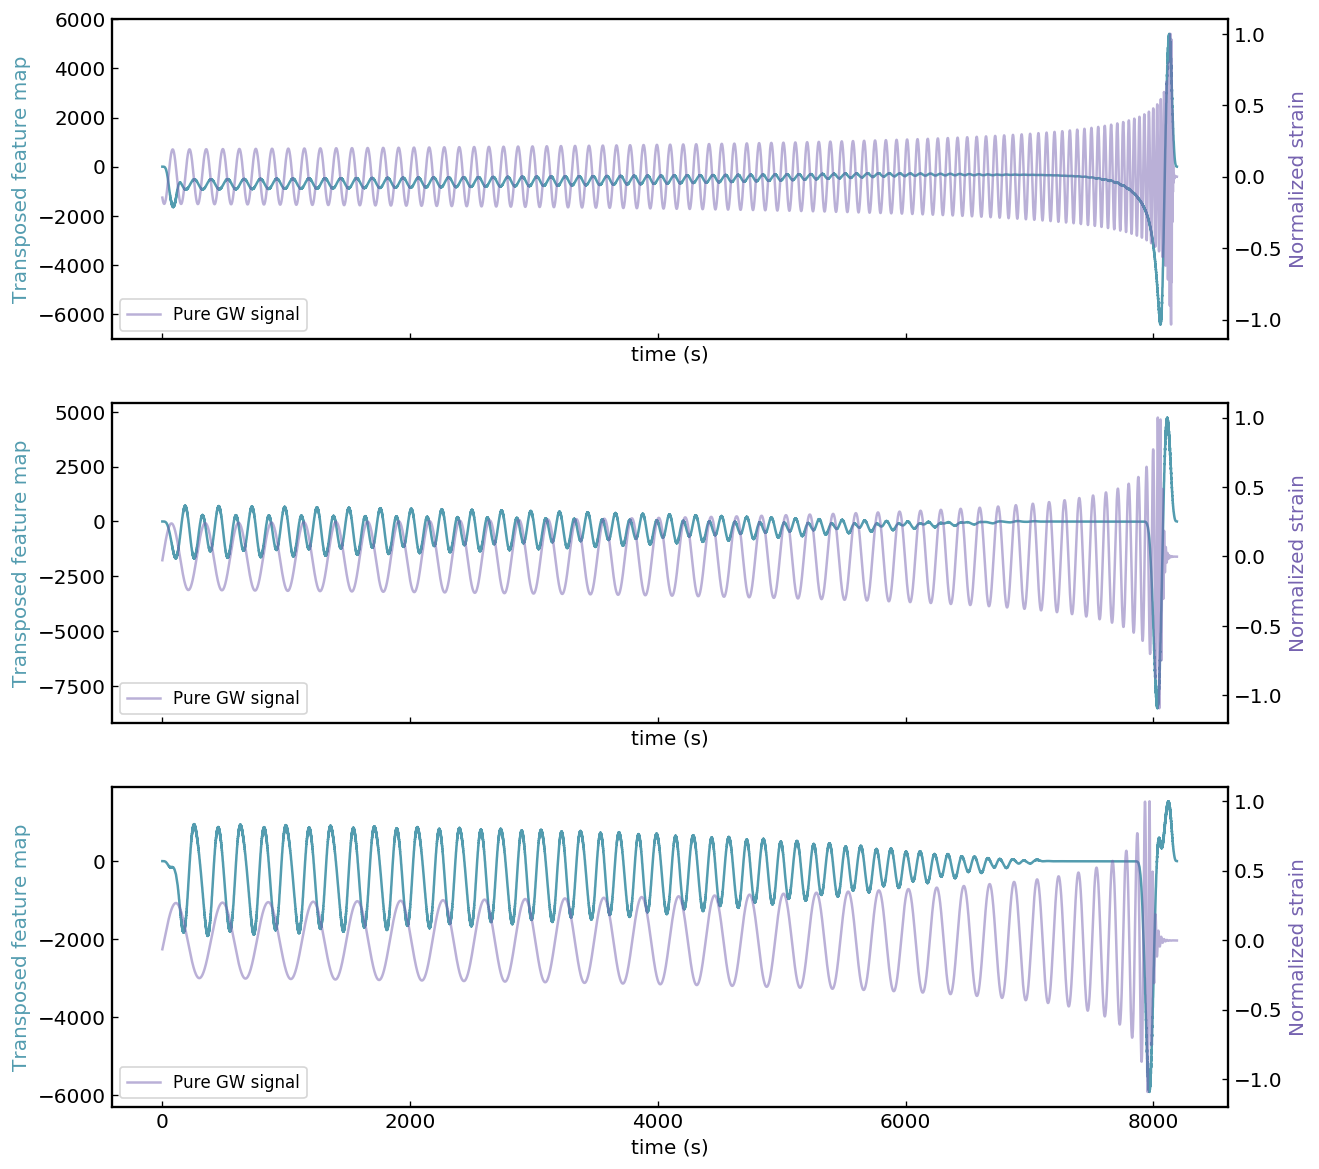

In [128]:
deconv(mass1 = '5|5.0', mass2 = '15|15.0', mass3 = '25|25.0',  item = 23)

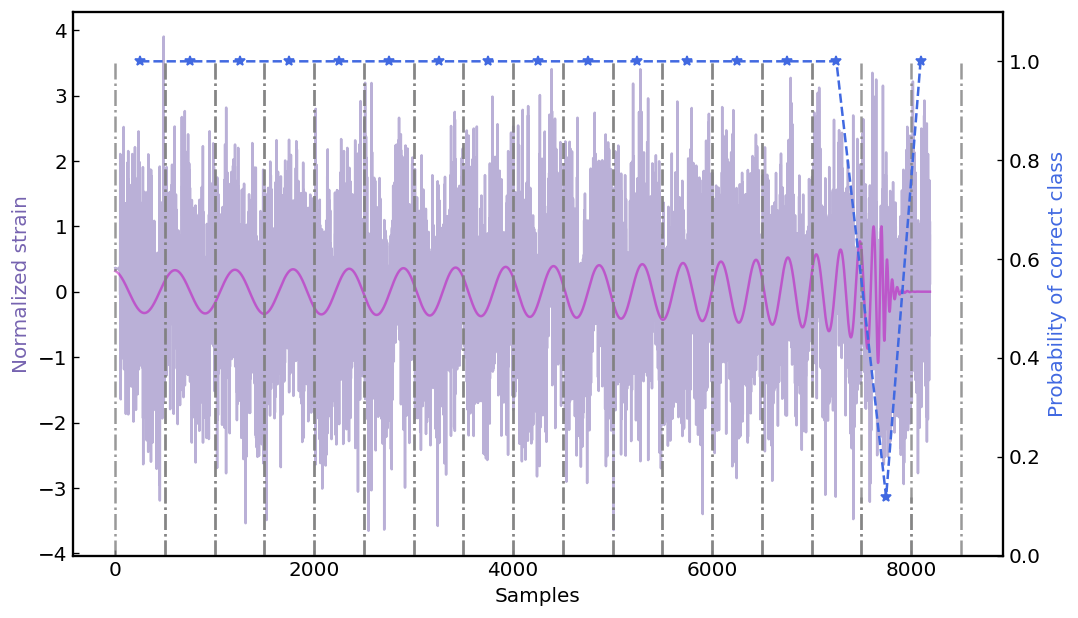

In [84]:
SNR = 1
params = nd.load('./info_1/params')
output_softmax = []

maxvalue = 8192
step = 500
ll = [(i*step, i*step+step) for i in range(maxvalue) if i*step+step < maxvalue] +[(maxvalue//step * step,maxvalue)]

data_norm = Normolise(data_GW_train.loc[['55|55.0']])
noise = noise3.sample(1,random_state = 1)    
sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1)) 
data_mixed = data_norm.div(sigma, axis=0) + np.array(noise)
data_norm = np.array(data_norm.div(sigma, axis=0))[0]

x = []

plt.figure(figsize=(12,6))
_, ax1 = plt.subplots()
ax1.plot(data_mixed.values[0].tolist(), alpha = 0.5, color = '#7663b0')
ax1.plot(data_norm.tolist() , alpha = 0.5, color = 'm')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Normalized strain',color = '#7663b0')
ax2 = ax1.twinx()
for (i, j) in ll:
    data_norm = Normolise(data_GW_train.loc[['55|55.0']])
    noise = noise3.sample(1,random_state = 1)    
    sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1)) 
    
    data_norm = np.array(data_norm.div(sigma, axis=0))[0]
    data_norm_mean = data_norm.mean()
    data_norm[i:j] = data_norm_mean
#     data_norm = pd.DataFrame(data_norm)
#     data_norm[2000:2200] = data_norm_mean
    data_mixed = data_norm + np.array(noise)
    vir_mixed = nd.array(data_mixed.tolist()).as_in_context(ctx).reshape((1,1,1,-1))
    vir_data = nd.array(data_norm.tolist()).as_in_context(ctx).reshape((1,1,1,-1))
    
    output, interlayer = net(vir_mixed, params)
    # h1, h2, h3, h4, h5 = interlayer
    output_softmax.append(nd.softmax(output).asnumpy().tolist()[0][1])
    output_softmax
#     ax2.bar(i+step/2,1.1+output_softmax[-1],step,-1.1, color = '#539caf', alpha = 0.3)
    ax2.vlines(i,0,output_softmax[-1],'grey','-.', alpha = 0.8)
    ax2.vlines(i+step,0,output_softmax[-1],'grey','-.', alpha = 0.8)
    ax2.set_ylim(0,1.1)
    
    x.extend([i + (j-i)/2])
plt.plot(x, output_softmax,'*--',alpha = 1, color='#4169E1')
ax2.set_ylabel('Probability of correct class', color= '#4169E1')
plt.savefig('./images/probility_mask.png')

In [231]:
def pos_gap(samples):
    positions = []
    gaps = []
    for sam in samples.values.tolist():
        position = [index for index, value in enumerate(sam) if (sam[index-1] * sam[index]  < 0) & (index != 0)]
        gaps.append([position[i+1] - j for i,j in enumerate(position) if j != position[-1] ])
        positions.append(position)
    return positions, gaps

In [299]:
def Fisco(m1, m2):
    c = 299792458 # m/s
    G = 6.67259e-11 # N m^2/kg^2
    Msun = 1.989e30 # kg
    f_isco = c**3/np.sqrt(6)/6/2/np.pi/G/Msun
    return f_isco/(m1+m2)

Fisco(5,5)

219.84983370575628

In [300]:
positions, gaps = pos_gap(Normolise(data_GW_train[data_GW_train.index == '5|5.0']))
gaps
# positions

[[68,
  68,
  68,
  67,
  67,
  67,
  67,
  67,
  66,
  67,
  66,
  66,
  65,
  65,
  66,
  65,
  64,
  65,
  64,
  64,
  64,
  64,
  63,
  63,
  63,
  63,
  63,
  62,
  62,
  62,
  62,
  61,
  61,
  61,
  61,
  60,
  61,
  60,
  60,
  59,
  60,
  59,
  59,
  58,
  59,
  58,
  58,
  57,
  58,
  57,
  57,
  57,
  57,
  56,
  56,
  56,
  55,
  56,
  55,
  55,
  54,
  54,
  55,
  53,
  54,
  53,
  54,
  52,
  53,
  52,
  52,
  52,
  52,
  51,
  51,
  51,
  51,
  50,
  50,
  50,
  49,
  49,
  50,
  48,
  49,
  48,
  48,
  47,
  48,
  47,
  47,
  46,
  47,
  45,
  46,
  46,
  45,
  45,
  44,
  44,
  45,
  43,
  44,
  43,
  43,
  42,
  42,
  42,
  42,
  41,
  42,
  40,
  41,
  40,
  40,
  39,
  39,
  39,
  39,
  38,
  38,
  38,
  37,
  37,
  36,
  37,
  36,
  35,
  36,
  35,
  34,
  34,
  34,
  34,
  33,
  33,
  32,
  32,
  32,
  31,
  31,
  31,
  30,
  30,
  30,
  29,
  28,
  28,
  28,
  28,
  27,
  26,
  26,
  26,
  25,
  25,
  24,
  24,
  23,
  23,
  23,
  22,
  21,
  21,
  20,
  20,
  19

In [298]:
for index, value in enumerate(gaps[0]):
    if value <= Fisco(55,55): 
        print(positions[index])
        break

IndexError: list index out of range

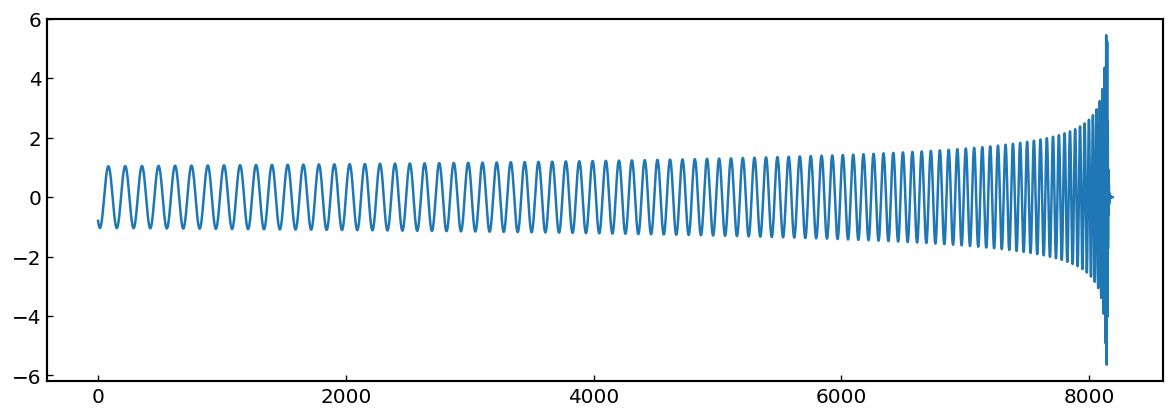

In [267]:
plt.figure(figsize=(12,4))
plt.plot(np.array(Normolise(data_GW_train[data_GW_train.index == '5|5.0']))[0])

In [149]:
SNR = 1
params = nd.load('./info_1/params')
data_norm = Normolise(data_GW_train.loc[['5|5.0']])
noise = noise3.sample(1,random_state = 1)    
sigma = data_norm.max(axis=1) / SNR / np.sqrt(np.array(noise).std(axis=1))  

data_norm = np.array(data_norm)[0]
data_norm_mean = data_norm.mean()
data_norm[1000:2150] = data_norm_mean
data_norm[1000:2150]

array([  1.21430643e-17,   1.21430643e-17,   1.21430643e-17, ...,
         1.21430643e-17,   1.21430643e-17,   1.21430643e-17])

In [ ]:
    from scipy.interpolate import interp1d  # Interpolate a 1-D function.
    is_GW = False; is_PureN = False ; is_mixed = True ; debug = False ;
    maxvalue = 8192
    step = 510
    ll = [(i*step, i*step+step) for i in range(maxvalue) if i*step+step < maxvalue] +[(maxvalue//step * step,maxvalue)]
    output = []
    output_softmax = []
    for (i, j) in ll:
        np.random.seed(1024)
        if is_PureN:
            sigma = 5
            noise = sigma * np.random.normal(size=8192)  
            test = noise
        if is_GW:
            test = Normolise(data_GW_test.loc[['10|10.0']])[0]
        if is_mixed:
            sigma = 5
            noise = sigma * np.random.normal(size=8192)              
            test = noise + Normolise(data_GW_test.loc[['10|10.0']])[0]

        test_mean = test.mean()
    #         i = 7000;
    #         j = 8000;
        test[i:j] = test_mean
        if debug:
            plt.plot(test)
            plt.show()
            print(i, j)
            continue
        test_data = nd.array(test).as_in_context(ctx).reshape((1,1,1,-1))
        output_, h1_, h2_, h3_, h4_, h5_ = net(test_data)
        output.append(output_.asnumpy().tolist())
        output_softmax.append(nd.softmax(output_).asnumpy().tolist())
    #         if (i <= 7000) & (i>=6500):
        if i == 7200:
    #             output0 = output_softmax
            test0 = test
    #     return np.array(output).reshape(-1,2), np.array(output_softmax).reshape(-1,2)
    #     return np.array(output_softmax).reshape(-1,2)